# Simulation of Phonon Scattering in Single Crystal Silicon

Instrument: ARCS
* Ei=100meV
* Fermi chopper: 600 Hz
* T0: 120Hz
 
Sample: silicon


## Step 0. some goodies

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import histogram.hdf as hh, histogram as H

/home/lj7/anaconda2/envs/mcvine/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Step 1. Prepare input data

In [6]:
# Change this!!!
inputsdir = "/SNS/users/lj7/simulations/ARCS/Si/demo/inputs"
!mkdir -p {inputsdir}

In [109]:
%cd {inputsdir}
#!ls -l

/SNS/users/lj7/simulations/ARCS/Si/demo/inputs


### Beam

In [8]:
!ln -s /SNS/users/lj7/simulations/ARCS/beam/100meV beam

<IPython.core.display.Javascript object>


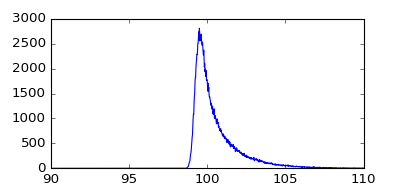

In [19]:
# check beam
import histogram.hdf as hh
ie = hh.load("beam/out/ienergy.h5")
plt.plot(ie.energy, ie.I)

### Sample

In [23]:
!rsync -avzL /SNS/users/lj7/simulations/samples/Si/demo/ sampleassembly/

sending incremental file list
created directory sampleassembly
./
.sampleassembly.xml.swp
Si-scatterer.xml
Si.xyz
sampleassembly.xml
Si-phonons/
Si-phonons/DOS
Si-phonons/FORCE_CONSTANTS
Si-phonons/Omega2
Si-phonons/POSCAR
Si-phonons/Polarizations
Si-phonons/Qgridinfo
Si-phonons/compute.py
Si-phonons/dos-withbroadening.dat
Si-phonons/run.sh

sent 72,300,928 bytes  received 315 bytes  9,640,165.73 bytes/sec
total size is 91,492,002  speedup is 1.27


In [24]:
!find .

.
./beam
./sampleassembly
./sampleassembly/Si-phonons
./sampleassembly/Si-phonons/DOS
./sampleassembly/Si-phonons/FORCE_CONSTANTS
./sampleassembly/Si-phonons/Omega2
./sampleassembly/Si-phonons/POSCAR
./sampleassembly/Si-phonons/Polarizations
./sampleassembly/Si-phonons/Qgridinfo
./sampleassembly/Si-phonons/compute.py
./sampleassembly/Si-phonons/dos-withbroadening.dat
./sampleassembly/Si-phonons/run.sh
./sampleassembly/.sampleassembly.xml.swp
./sampleassembly/Si-scatterer.xml
./sampleassembly/Si.xyz
./sampleassembly/sampleassembly.xml


### Scattering template

In [25]:
!mkdir {inputsdir}/scattering
%cd "{inputsdir}/scattering"

/SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering


In [27]:
!rsync -a /SNS/users/lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/* ./
!ls

scripts  template


In [28]:
%cd template/

/SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering/template


In [29]:
!ln -s ../../sampleassembly
!ln -s ../../beam
%cd ..

/SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering


## Step 2. Staging the simulation files

In [60]:
cluster = "ndav2.sns.gov"
workdir = "/SNS/users/lj7/simulations/ARCS/Si/June2016/test-orientation"

In [61]:
!mkdir -p {workdir}

In [82]:
%%file {inputsdir}/scattering/sim.yml

cluster:
  nodes: 50
instrument:
  name: arcs
scatter:
  ncount: 1e8
  multiple_scattering: off
  template: ./template

Overwriting /SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering/sim.yml


In [81]:
# staging
# don't use -L for rsync, otherwise the beam and sampleassembly will be copied a lot of times
!rsync -avz {inputsdir}/ {cluster}:{workdir}/

sending incremental file list
scattering/
scattering/sim.yml

sent 3,379 bytes  received 134 bytes  1,405.20 bytes/sec
total size is 232,660,241  speedup is 66,228.36


## Step 3. Test drive

In [68]:
setupenv_cluster = ". ~/.use-miniconda2; source activate mcvine "

In [76]:
cmd = "time ./scripts/sim.py --angle=30.0"

In [77]:
print cluster, setupenv_cluster, workdir, cmd

ndav2.sns.gov . ~/.use-miniconda2; source activate mcvine  /SNS/users/lj7/simulations/ARCS/Si/June2016/test-orientation time ./scripts/sim.py --angle=30.0


In [79]:
!ssh -f {cluster} "bash -c '{setupenv_cluster}; cd {workdir}/scattering; {cmd} </dev/null >log.-30.0 2>&1 &'"

In [57]:
#!ssh {cluster} "bash -c 'ls < /dev/null > ~/log.ls &'"

In [56]:
#!ssh {cluster} ls

** Timing: n=1e8. 1.5 hours **

## Step 4. Run all angles

In [102]:
%%file {inputsdir}/scattering/sim.yml

cluster:
  nodes: 1
instrument:
  name: arcs
scatter:
  ncount: 1e7
  multiple_scattering: off
  template: ./template

Overwriting /SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering/sim.yml


In [88]:
%%file {inputsdir}/scattering/create_sim_all.py
import numpy as np
ostream = open('simall.sh', 'wt')
for a in np.arange(-5, 90.1, 2.):
    ostream.write('time ./scripts/sim.py --angle=%s >log.%s 2>&1 &\n' % (a,a))
    continue
ostream.close()

Overwriting /SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering/create_sim_all.py


In [85]:
%cd {inputsdir}/scattering

/SNS/users/lj7/simulations/ARCS/Si/demo/inputs/scattering


In [89]:
!python ./create_sim_all.py

In [91]:
#!cat simall.sh

In [94]:
!chmod +x simall.sh

In [103]:
# staging
# don't use -L for rsync, otherwise the beam and sampleassembly will be copied a lot of times
!rsync -avz {inputsdir}/ {cluster}:{workdir}/

sending incremental file list
cannot delete non-empty directory: beam
could not make way for new symlink: beam
scattering/
scattering/sim.yml

sent 1,620 bytes  received 177 bytes  3,594.00 bytes/sec
total size is 91,522,181  speedup is 50,930.54
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1183) [sender=3.1.0]


In [96]:
cmd = "./simall.sh"

In [104]:
# one last check of sim config
!ssh {cluster} cat {workdir}/scattering/sim.yml


cluster:
  nodes: 1
instrument:
  name: arcs
scatter:
  ncount: 1e7
  multiple_scattering: off
  template: ./template

In [97]:
print cluster, setupenv_cluster, workdir, cmd

ndav2.sns.gov . ~/.use-miniconda2; source activate mcvine  /SNS/users/lj7/simulations/ARCS/Si/June2016/test-orientation ./simall.sh


In [98]:
!echo ssh -f {cluster} "bash -c '{setupenv_cluster}; cd {workdir}/scattering; {cmd} </dev/null >log.simall 2>&1 &'"

ssh -f ndav2.sns.gov bash -c '. ~/.use-miniconda2; source activate mcvine ; cd /SNS/users/lj7/simulations/ARCS/Si/June2016/test-orientation/scattering; ./simall.sh </dev/null >log.simall 2>&1 &'


In [105]:
!ssh -f {cluster} "bash -c '{setupenv_cluster}; cd {workdir}/scattering; {cmd} </dev/null >log.simall 2>&1 &'"

## Step 5. Reduction

In [112]:
# Here we run reduction locally for convenience, taking advantage
# locally mounted folders.
# When this is not practical, reduction can be run remotely too.
%cd "{workdir}/scattering"
!ls

/SNS/users/lj7/simulations/ARCS/Si/June2016/test-orientation/scattering
create_sim_all.py  log.37.0  log.69.0	 template   work_37.0  work_69.0
log.-1.0	   log.39.0  log.7.0	 work_-1.0  work_39.0  work_7.0
log.1.0		   log.41.0  log.71.0	 work_1.0   work_41.0  work_71.0
log.11.0	   log.43.0  log.73.0	 work_11.0  work_43.0  work_73.0
log.13.0	   log.45.0  log.75.0	 work_13.0  work_45.0  work_75.0
log.15.0	   log.47.0  log.77.0	 work_15.0  work_47.0  work_77.0
log.17.0	   log.49.0  log.79.0	 work_17.0  work_49.0  work_79.0
log.19.0	   log.-5.0  log.81.0	 work_19.0  work_-5.0  work_81.0
log.21.0	   log.5.0   log.83.0	 work_21.0  work_5.0   work_83.0
log.23.0	   log.51.0  log.85.0	 work_23.0  work_51.0  work_85.0
log.25.0	   log.53.0  log.87.0	 work_25.0  work_53.0  work_87.0
log.27.0	   log.55.0  log.89.0	 work_27.0  work_55.0  work_89.0
log.29.0	   log.57.0  log.9.0	 work_29.0  work_57.0  work_9.0
log.-3.0	   log.59.0  log.reduce  work_-3.0  work_59.0
log.3.0		   log.61.0  log.simall  work

First we reduce event-mode nexus data for each angle using Mantid

In [107]:
# check if there is reduced data
!ls work_2.0/reduced*

ls: cannot access work_2.0/reduced*: No such file or directory


In [108]:
# reduce tof events to E events
# this takes about 30 minutes
!./scripts/reduce/reduceKeepingEvents_batch.py -5,90.1,2. 100 0,75,0.5 > log.reduce

In [110]:
# create configuration file for getting a slice

In [114]:
ha = 2.71526503565
a = ha*2
print a

5.4305300713


In [115]:
%%file slice_111.yml

angles: -5,90.1,2.0
filename_pattern: work_%(angle)s/reduced_%(angle)s.nxs
lattice: 5.4305300713, 5.4305300713, 5.4305300713, 90, 90, 90
orientation:
 u: -1, 1, -1
 v: 2,1,-1
Eaxis:
 min: 0
 max: 75
 N: 151
Q_projections:
 U:
  proj: -1,1,-1
  proj_name: -H,H,-H
  min: -6
  max: 6
  N: 241
 V:
  proj: 1,.5,-.5
  proj_name: H,0.5H,-0.5H
  min: -5.45
  max: -5.15
  N: 1
 W:
  proj: 0,-1,-1
  proj_name: 0,-K,-K
  min: -0.3
  max: 0.3
  N: 1
output: slice_111.nxs


Writing slice_111.yml


In [116]:
# hack for now. copy the config python file to current dir
!cp /SNS/users/lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/scripts/config.py .

In [117]:
# run script to calculate the slice
# this take ~15 minutes 
! PYTHONPATH=$PWD:$PYTHONPATH ./scripts/reduce/getaslice.py slice_111.yml > log.slice_111

In [118]:
# convert slice nexus to slice histogram for plotting
!./scripts/reduce/slice2hist.py slice_111.nxs slice_111.h5

FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.97 seconds


plot z in (0, 1e-06)


<IPython.core.display.Javascript object>


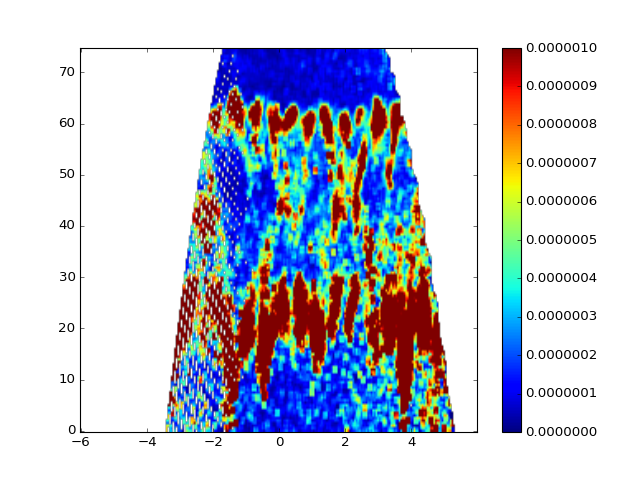

In [120]:
# plot
H.plot(hh.load("./slice_111.h5"), min=0, max=1e-6)

### Comments
This simulation has 2 degrees step size and was not run too long. Result is noisy. It was a quick simulation (~6hours). It is OK. We can run longer on different computing resources.